In [4]:
# from https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/cgan/cgan.py

import os
os.environ['CUDA_DEVICE_ID'] = 'PCI_BUS_ORDER'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import argparse
import math
import random

import numpy as np
from tqdm.auto import tqdm
import IPython.display as ipd
from PIL import Image

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets

import torch.nn as nn
import torch.nn.functional as F
import torch

cuda = True if torch.cuda.is_available() else False

In [5]:
MNIST    = 'mnist'        # https://en.wikipedia.org/wiki/MNIST_database
F_MNIST  = 'fashion_mnist' # https://github.com/zalandoresearch/fashion-mnist
CIFAR10 = 'cifar10'     # https://www.cs.toronto.edu/~kriz/cifar.html

DATA_NAME = MNIST 


DATA_DIR = f'data/{DATA_NAME}'
GEN_DIR = f'gen_images_{DATA_NAME}'
os.makedirs(GEN_DIR, exist_ok=True)

print(f'torch.version:{torch.__version__}')
print(f'cuda:{cuda}')


!python --version
!pwd
!ls -l

torch.version:1.9.1
cuda:True
Python 3.7.12
/kaggle/working
total 8
---------- 1 root root  263 Feb 28 07:13 __notebook_source__.ipynb
drwxr-xr-x 2 root root 4096 Feb 28 07:13 gen_images_mnist


In [6]:
n_channel = {MNIST:1, F_MNIST:1, CIFAR10:3}[DATA_NAME]
img_size =  {MNIST:28, F_MNIST:28, CIFAR10:32}[DATA_NAME]
VISION_DATASET =  {MNIST:datasets.MNIST, F_MNIST:datasets.FashionMNIST, CIFAR10:datasets.CIFAR10}[DATA_NAME]

class Option:
    def __init__(self):
        self.n_epochs = 50         # number of epochs of training
        self.batch_size = 64       # size of the batches
        self.lr = 0.0002           # adam: learning rate
        self.b1 = 0.5              # adam: decay of first order momentum of gradient
        self.b2 = 0.999            # adam: decay of first order momentum of gradient
        self.n_cpu = 2             # number of cpu threads to use during batch generation
        self.latent_dim = 100      # dimensionality of the latent space
        self.n_classes = 10        # number of classes for dataset
        self.img_size = img_size   # size of each image dimension
        self.channels = n_channel  # number of image channels
        self.sample_interval = 400 # interval between image sampling")
        
opt = Option()
vars(opt)

{'n_epochs': 50,
 'batch_size': 64,
 'lr': 0.0002,
 'b1': 0.5,
 'b2': 0.999,
 'n_cpu': 2,
 'latent_dim': 100,
 'n_classes': 10,
 'img_size': 28,
 'channels': 1,
 'sample_interval': 400}

In [7]:
img_shape = (opt.channels, opt.img_size, opt.img_size)

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(opt.n_classes, opt.n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim + opt.n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img
    
# Create generator 
generator = Generator()
generator

Generator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(opt.n_classes, opt.n_classes)

        self.model = nn.Sequential(
            nn.Linear(opt.n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

# Create discriminator
discriminator = Discriminator()
discriminator

Discriminator(
  (label_embedding): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): Dropout(p=0.4, inplace=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [10]:
# Loss functions
adversarial_loss = torch.nn.MSELoss()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    

In [11]:
# Configure data loader

os.makedirs(DATA_DIR, exist_ok=True)

ds = VISION_DATASET(DATA_DIR, train=True,download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), 
             transforms.ToTensor(), 
             transforms.Normalize([0.5], [0.5])
            ]
        ),
    )

dataloader = torch.utils.data.DataLoader(
    ds,
    batch_size=opt.batch_size,
    shuffle=True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


[6] 6 - six


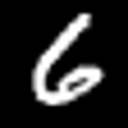

[7] 7 - seven


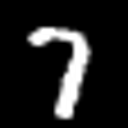

[2] 2 - two


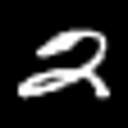

[0] 0 - zero


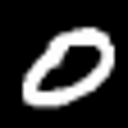

[6] 6 - six


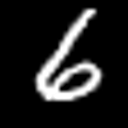

[9] 9 - nine


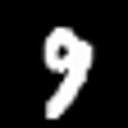

[8] 8 - eight


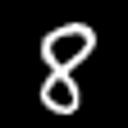

[6] 6 - six


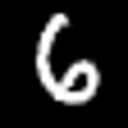

[6] 6 - six


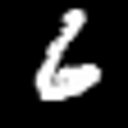

[9] 9 - nine


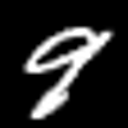

In [12]:
for _ in range(10):
    img, label =  random.choice(ds)
    img = ((img + 1)/2*255).type(torch.uint8).permute((1,2,0)).squeeze()
    print(f'[{label}] {ds.classes[label]}')
    display(Image.fromarray(img.numpy()).resize((128, 128)))

In [13]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [14]:
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

def sample_image(n_width, epoch, n_label = 10):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = torch.Tensor(np.random.normal(0, 1, (n_width* n_label, opt.latent_dim))).type(FloatTensor)
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([label for label in range(n_label) for _ in range(n_width)])
    labels = torch.Tensor(labels).type(LongTensor)
    gen_imgs = generator(z, labels)
    img_path = f"{GEN_DIR}/{epoch:06d}.png"
    save_image(gen_imgs.data, img_path, nrow=n_width, normalize=True)
    return img_path

3/50
D loss: 0.0759,  G loss: 0.8293428421020508


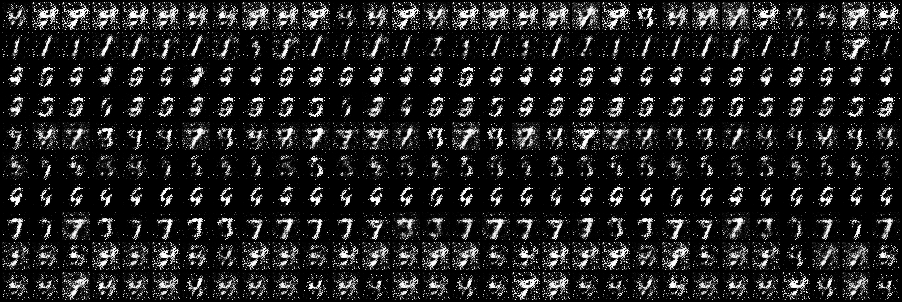

  0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
# ----------
#  Training
# ----------

for epoch in range(opt.n_epochs):
    print(f'{epoch+1}/{opt.n_epochs}')
    if epoch:
        print(f'D loss: {d_loss.item():.04f},  G loss: {g_loss.item()}')
        display(Image.open(img_path))
        
        
    for i, (imgs, labels) in enumerate(tqdm(dataloader)):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = FloatTensor(batch_size, 1).fill_(1.0)
        fake  = FloatTensor(batch_size, 1).fill_(0.0)

        # Configure input
        real_imgs = imgs.type(FloatTensor)
        labels = labels.type(LongTensor)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = FloatTensor(np.random.normal(0, 1, (batch_size, opt.latent_dim)))
        gen_labels = LongTensor(np.random.randint(0, opt.n_classes, batch_size))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

    img_path = sample_image(n_width=30, epoch=epoch, n_label=opt.n_classes)
    ipd.clear_output(wait=True)